https://huggingface.co/facebook/detr-resnet-50


In [ ]:
!pip install tensorflow opencv-python opencv-python-headless


In [ ]:
!pip install tensorflow tensorflow-hub opencv-python-headless

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load pre-trained object detection model from TensorFlow Hub
def load_model():
    model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")
    return model

def load_labels():
    label_map_url = "https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt"
    labels = {}
    response = requests.get(label_map_url)
    for line in response.text.split('\n'):
        if "id:" in line:
            id = int(line.split(":")[1])
        if "display_name:" in line:
            display_name = line.split(":")[1].replace('"', '').strip()
            labels[id] = display_name
    return labels

# Perform object detection
def detect_objects(image_path, model, labels):
    img = Image.open(image_path)
    img_np = np.array(img)
    input_tensor = tf.convert_to_tensor(img_np)
    input_tensor = input_tensor[tf.newaxis,...]

    results = model(input_tensor)

    detection_boxes = results["detection_boxes"].numpy()[0]
    detection_classes = results["detection_classes"].numpy()[0].astype(np.int64)
    detection_scores = results["detection_scores"].numpy()[0]

    img_with_detections = img_np.copy()
    height, width, _ = img_np.shape

    for i in range(len(detection_scores)):
        if detection_scores[i] >= 0.5:
            box = detection_boxes[i] * [height, width, height, width]
            ymin, xmin, ymax, xmax = box.astype(int)
            cv2.rectangle(img_with_detections, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
            label = labels[detection_classes[i]]
            cv2.putText(img_with_detections, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return img_with_detections

# Display the image with detected objects
def display_image(img_with_detections):
    plt.figure(figsize=(10,10))
    plt.imshow(img_with_detections)
    plt.axis('off')
    plt.show()

# Load the model and labels
model = load_model()
labels = load_labels()



FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_image.jpg'

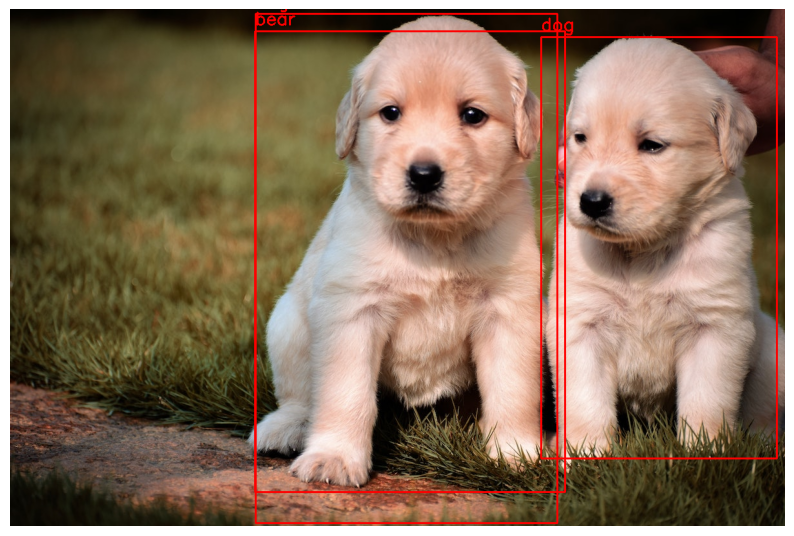

In [ ]:
# Path to the input image
image_path = "path_to_image.jpeg"

# Detect objects and display the image
img_with_detections = detect_objects(image_path, model, labels)
display_image(img_with_detections)


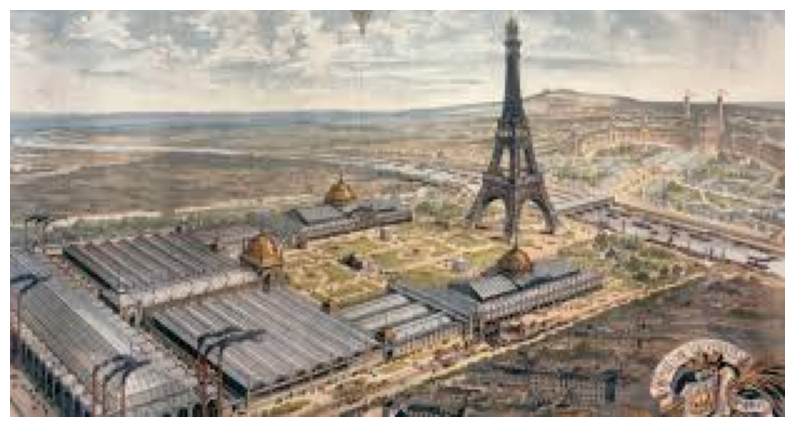

In [ ]:
# Path to the input image
image_path = "images.jpeg"

# Detect objects and display the image
img_with_detections = detect_objects(image_path, model, labels)
display_image(img_with_detections)


# V2 for captioning

In [ ]:
!pip install transformers datasets torch torchvision pillow opencv-python-headless matplotlib
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 37.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

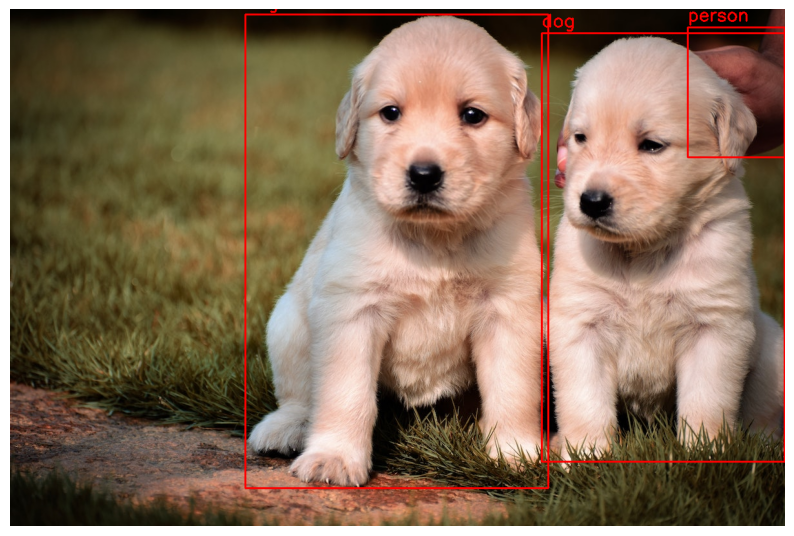

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated Caption: two pup are sitting in the grass


In [ ]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import DetrImageProcessor, DetrForObjectDetection
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load object detection model from Hugging Face
def load_detection_model():
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
    return processor, model

# Perform object detection
def detect_objects(image_path, processor, model):
    img = Image.open(image_path)
    inputs = processor(images=img, return_tensors="pt")
    outputs = model(**inputs)

    # let's only keep detections with score > 0.9
    target_sizes = torch.tensor([img.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    img_with_detections = np.array(img)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        img_with_detections = cv2.rectangle(img_with_detections, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
        img_with_detections = cv2.putText(img_with_detections, model.config.id2label[label.item()], (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return img_with_detections

# Display the image with detected objects
def display_image(img_with_detections):
    plt.figure(figsize=(10,10))
    plt.imshow(img_with_detections)
    plt.axis('off')
    plt.show()

# Load image captioning model from Hugging Face
def load_captioning_model():
    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    return processor, model

# Generate caption using the pre-trained model
def generate_caption(image_path, processor, model):
    image = Image.open(image_path)
    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

# Load the models
detection_processor, detection_model = load_detection_model()
captioning_processor, captioning_model = load_captioning_model()

# Path to the input image
image_path = "path_to_your_image.jpeg"

# Detect objects and display the image
img_with_detections = detect_objects(image_path, detection_processor, detection_model)
display_image(img_with_detections)

# Generate and print the caption
caption = generate_caption(image_path, captioning_processor, captioning_model)
print("Generated Caption:", caption)


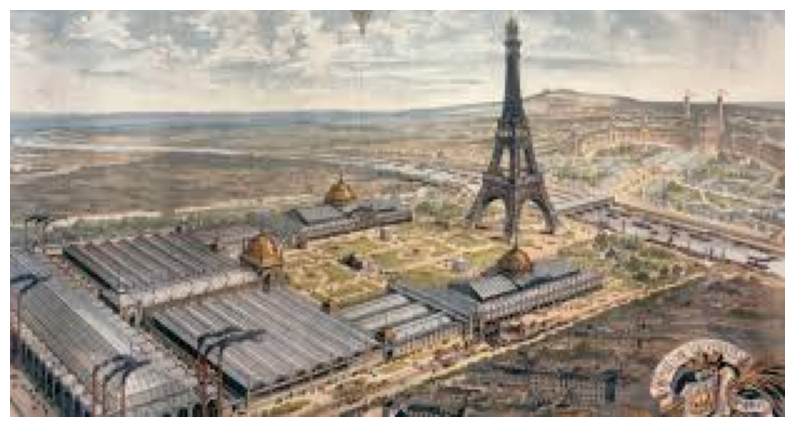

Generated Caption: an aerial view of paris, with the eiffiffiffiffiffiffiffiffiffiff


In [ ]:
image_path = "images.jpeg"

img_with_detections = detect_objects(image_path, detection_processor, detection_model)
display_image(img_with_detections)

caption = generate_caption(image_path, captioning_processor, captioning_model)
print("Generated Caption:", caption)

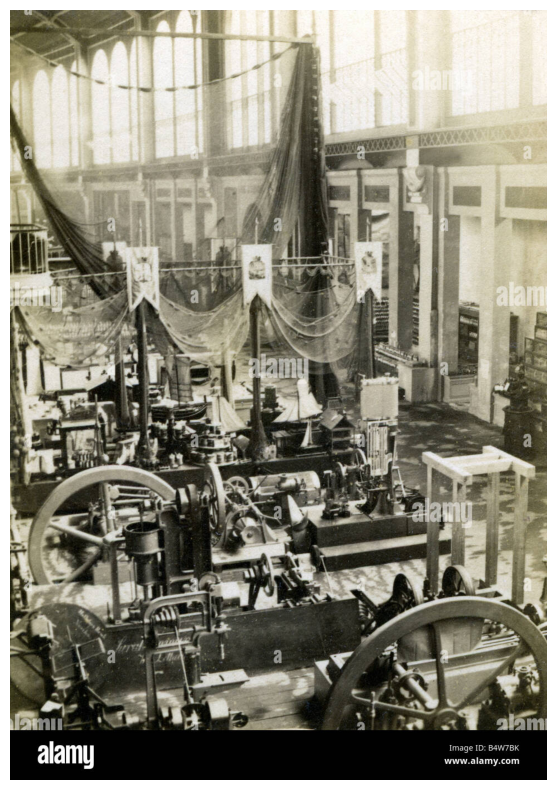

Generated Caption: the factory of the german factory of the german manufacturer, the german manufacturer, in the city of


In [ ]:
image_path = "exhibitions-world-exposition-paris-141867.jpg"

img_with_detections = detect_objects(image_path, detection_processor, detection_model)
display_image(img_with_detections)

caption = generate_caption(image_path, captioning_processor, captioning_model)
print("Generated Caption:", caption)

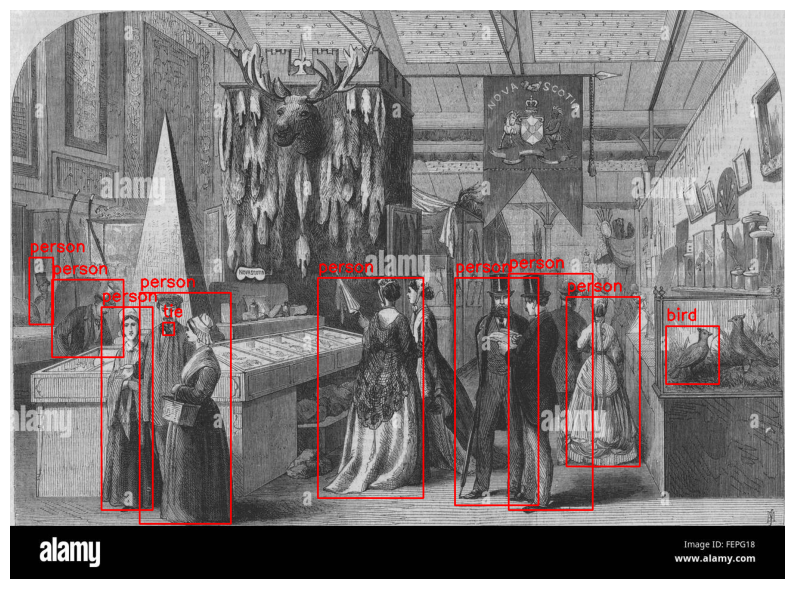

Generated Caption: the fish market in london, england, engraving from the illustrated by the illustrated magazine, - stock


In [ ]:
# Path to the input image
image_path = "canada-exposition-universelle-1867-the-nova-scotia-section-1867-illustrated-FEPG18.jpg"

# Detect objects and display the image
img_with_detections = detect_objects(image_path, detection_processor, detection_model)
display_image(img_with_detections)

# Generate and print the caption
caption = generate_caption(image_path, captioning_processor, captioning_model)
print("Generated Caption:", caption)